In [17]:
pip install transformers torch torchvision PIL matplotlib

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [18]:
#Import Required Libraries

import os
import torch
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from transformers import ViltProcessor, ViltForImagesAndTextClassification

In [19]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, BertTokenizer

In [20]:
# Load pre-trained model and processor
feature_extractor = ViTImageProcessor.from_pretrained("atasoglu/vit-bert-flickr8k")
tokenizer = BertTokenizer.from_pretrained("atasoglu/vit-bert-flickr8k")
model = VisionEncoderDecoderModel.from_pretrained("atasoglu/vit-bert-flickr8k")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [21]:
# Load image captioning dataset

def load_captions(captions_file):
    image_captions = {}
    with open(captions_file, 'r') as file:
        for line in file:
            parts = line.strip().split('#', 2)
            if len(parts) != 3:
                continue
            img_id, _, caption = parts
            if img_id not in image_captions:
                image_captions[img_id] = []
            image_captions[img_id].append(caption)
    return image_captions

# Function to generate caption for a single image
def generate_caption(image_path):
    img = Image.open(image_path)
    pixel_values = feature_extractor(images=[img], return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(pixel_values)
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    return preds[0]


# Display images with captions in a single row
def display_images_with_captions(image_paths, captions):
    plt.figure(figsize=(24, 6))  
    for i, (image_path, caption) in enumerate(zip(image_paths, captions)):
        img = Image.open(image_path)
        plt.subplot(1, 5, i + 1)  # 1 row, 5 columns
        plt.imshow(img)
        plt.axis('off')
        plt.title(caption, fontsize=10, wrap=True)
    plt.tight_layout(pad=3.0) 
    plt.show()
    
# Path to dataset
image_folder = r'C:\Users\User\Workbooks\Dissertation\Flickr8k_Dataset\Flicker8k_Dataset'
captions_file = r'C:\Users\User\Workbooks\Dissertation\Flickr8k_text\Flickr8k.token.txt'


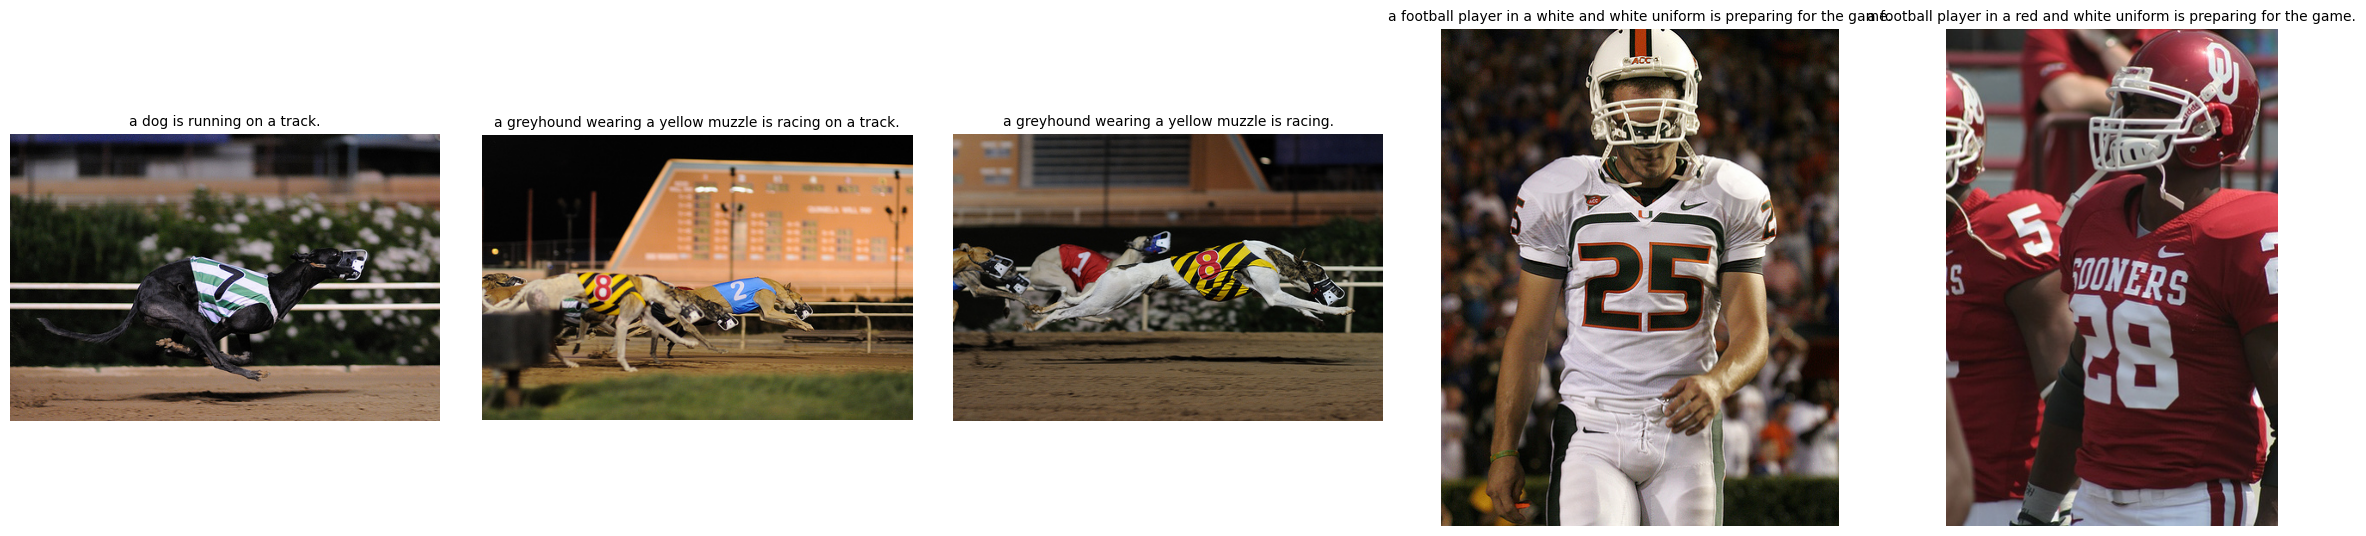

In [22]:
# Load captions
image_captions = load_captions(captions_file)

# Selecting random images
def get_random_images(image_captions, num_images=5):
    image_files = list(image_captions.keys())
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the dataset to select the requested number.")
    return random.sample(image_files, num_images)


random_image_files = get_random_images(image_captions)

# Generate captions for the selected images
image_paths = [os.path.join(image_folder, img_file) for img_file in random_image_files]
captions = [generate_caption(image_path) for image_path in image_paths]

# Display the images and their generated captions in a single row
display_images_with_captions(image_paths, captions)

In [23]:
# Display image with caption (Single Image)
def display_image_with_caption(image_path, caption):
    img = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption)
    plt.show()

Generated caption: a man in a blue shirt is standing next to a building.


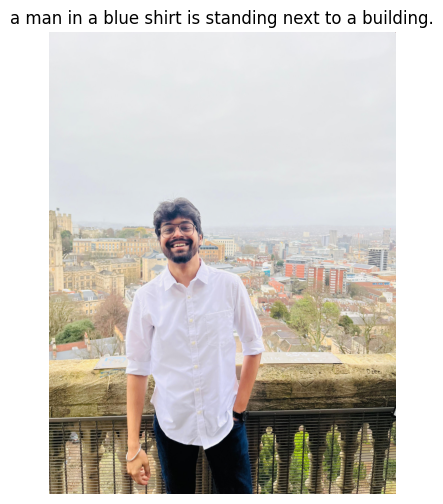

True captions for IMG-20231219-WA0018.jpg:


In [24]:
# Example usage: Generate caption for an image Manually

example_image = r'C:\Users\User\Downloads\Phone Link\IMG-20231219-WA0018.jpg'
generated_caption = generate_caption(example_image)
print(f'Generated caption: {generated_caption}')
display_image_with_caption(example_image, generated_caption)

# Optionally, print true captions
image_id = os.path.basename(example_image)
print(f'True captions for {image_id}:')
for caption in image_captions.get(image_id, []):
    print(f' - {caption}')

In [25]:
# Evaluation Metrics

In [26]:
pip install nltk pycocoevalcap

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Importing Necessary libraries for the Evaluation Metrics
import nltk
from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.meteor.meteor import Meteor
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

In [31]:
# Evaluation function
def evaluate_captions(generated_captions, reference_captions):
    refs = [[ref.split() for ref in refs_for_image] for refs_for_image in reference_captions]
    hyps = [gen_caption.split() for gen_caption in generated_captions]
    assert len(hyps) == len(refs)

    # Apply smoothing function to BLEU score
    smoothing_function = SmoothingFunction().method4
    bleu_score = corpus_bleu(refs, hyps, smoothing_function=smoothing_function)

    # METEOR Score
    meteor = Meteor()
    meteor_score, _ = meteor.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    # ROUGE Score
    rouge = Rouge()
    rouge_score, _ = rouge.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    # CIDEr Score
    cider = Cider()
    cider_score, _ = cider.compute_score({i: [" ".join(ref) for ref in refs[i]] for i in range(len(refs))}, {i: [" ".join(hyps[i])] for i in range(len(hyps))})

    return bleu_score, meteor_score, rouge_score, cider_score

In [32]:
# Load captions
image_captions = load_captions(captions_file)

# Select 5 random images
image_files = list(image_captions.keys())
random_image_files = random.sample(image_files, 5)

# Generate captions for the selected images
image_paths = [os.path.join(image_folder, img_file) for img_file in random_image_files]
generated_captions = [generate_caption(image_path) for image_path in image_paths]

# Reference captions for evaluation (list of lists, where each list corresponds to an image)
reference_captions = [image_captions[img_file] for img_file in random_image_files]

# Evaluate captions
bleu_score, meteor_score, rouge_score, cider_score = evaluate_captions(generated_captions, reference_captions)


In [33]:
print(f"BLEU Score: {bleu_score}")
print(f"METEOR Score: {meteor_score}")
print(f"ROUGE Score: {rouge_score}")
print(f"CIDEr Score: {cider_score}")

BLEU Score: 0.06910489932234326
METEOR Score: 0.13679594356217273
ROUGE Score: 0.19188801913114745
CIDEr Score: 0.7799022702126757
